In [1]:
import os
import shutil
import gc
from dotenv import load_dotenv

from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer
import chromadb

from langchain_cohere import ChatCohere
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage



d:\Learn\langchain\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

def env(key: str, default=None):
    return os.getenv(key, default)

# 🤖 LLM Configuration
COHERE_API_KEY = env("COHERE_API_KEY")
llm = ChatCohere(model="command-a-03-2025", cohere_api_key=COHERE_API_KEY) if COHERE_API_KEY else None

def enhance_query_with_llm(user_query: str) -> str:
    """Enhance user query using LLM for better semantic understanding"""
    if not llm:
        return user_query
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Bạn là trợ lý tối ưu hóa truy vấn tìm kiếm. Hãy cải thiện câu hỏi của người dùng để tìm kiếm bất động sản hiệu quả hơn. Chỉ trả về câu hỏi tối ưu, không thêm giải thích."),
        ("human", "{query}")
    ])
    chain = prompt | llm
    response = chain.invoke({"query": user_query})
    return response.content

def summarize_results_with_llm(query: str, search_results: list) -> str:
    """Summarize search results using LLM"""
    if not llm or not search_results:
        return "No results or LLM not configured"
    
    results_text = "\n".join([f"- {r.get('address')}: Giá {r.get('rent')}, {r.get('doc')[:200]}..." for r in search_results[:5]])
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Bạn là trợ lý bất động sản thông minh. Hãy tóm tắt và giải thích kết quả tìm kiếm cho người dùng một cách rõ ràng và hữu ích."),
        ("human", "Câu hỏi: {query}\n\nKết quả tìm kiếm:\n{results}")
    ])
    chain = prompt | llm
    response = chain.invoke({"query": query, "results": results_text})
    return response.content

In [3]:
MONGO_URL = env("MONGO_URL", "mongodb://localhost:27017")
MONGO_DB_NAME = env("DATABASE_NAME", "rag_db")

mongo_connection = MongoClient(MONGO_URL)
mongo_db = mongo_connection[MONGO_DB_NAME]

collection_mitsui = mongo_db['room_mitsui']
collection_tokyu = mongo_db['room_tokyu']

# Bước 1: Chuẩn hóa thông tin và tiền dữ liệu

In [4]:
# Lấy data
collections = [collection_mitsui, collection_tokyu]
data = [doc for col in collections for doc in col.find({}, {"_id": 0})]
df = pd.DataFrame(data)

if df.empty:
    print("⚠️ Không có dữ liệu trong collection.")
else:
    # 🧹 Bước 1: Loại bỏ các cột có prefix không cần thiết
    prefixes_to_drop = ("image_url_", "image_category_", "year", "map_lat", "map_lng", "link", "created_date")
    cols_to_drop = [col for col in df.columns if col.startswith(prefixes_to_drop)]
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # 🧠 Bước 2: Chuẩn hóa dữ liệu
    for col in df.columns:
        col_data = df[col].dropna()

        # Nếu toàn bộ cột rỗng -> mặc định là chuỗi rỗng
        if col_data.empty:
            df[col] = ''
            continue

        sample = col_data.iloc[0]

        # Xử lý boolean / Y-N -> Yes/No
        if isinstance(sample, bool):
            df[col] = df[col].apply(lambda x: 'Yes' if x else 'No')
        elif col_data.dtype == object and set(col_data.dropna().unique()).issubset({'Y', 'N'}):
            df[col] = df[col].apply(lambda x: 'Yes' if x == 'Y' else ('No' if x == 'N' else x))
        # Xử lý số
        elif np.issubdtype(type(sample), np.number):
            df[col] = df[col].fillna(0)
        # Xử lý chuỗi
        elif isinstance(sample, (str, bytes)):
            df[col] = df[col].fillna('')
        # Các kiểu khác (dict, list...) -> convert sang chuỗi
        else:
            df[col] = df[col].apply(lambda x: str(x) if pd.notna(x) else '')

    print("✅ DataFrame sau khi chuẩn hoá:")
    print(df.head())


✅ DataFrame sau khi chuẩn hoá:
     room_link              address prefecture                      city  \
0  mitsui_link  神奈川県川崎市中原区木月住吉町１０－１   Kanagawa  Kawasaki-shi Nakahara-ku   
1  mitsui_link  神奈川県川崎市中原区木月住吉町１０－１   Kanagawa  Kawasaki-shi Nakahara-ku   
2  mitsui_link  神奈川県川崎市中原区木月住吉町１０－１   Kanagawa  Kawasaki-shi Nakahara-ku   
3  mitsui_link  神奈川県川崎市宮前区宮崎３丁目９番地１   Kanagawa   Kawasaki-shi Miyamae-ku   
4  mitsui_link  神奈川県横浜市港北区新横浜１－６－１１   Kanagawa    Yokohama-shi Kohoku-ku   

              district  chome_banchi          building_name_en  \
0  Kizuki Sumiyoshicho  中原区木月住吉町１０－１     Trust Villa Sumiyoshi   
1  Kizuki Sumiyoshicho  中原区木月住吉町１０－１     Trust Villa Sumiyoshi   
2  Kizuki Sumiyoshicho  中原区木月住吉町１０－１     Trust Villa Sumiyoshi   
3             Miyazaki  宮前区宮崎３丁目９番地１  Flower House Miyazakidai   
4         Shinyokohama  港北区新横浜１－６－１１      Artene Shin-Yokohama   

  building_name_ja                            building_description_ja  floors  \
0         トラストビラ住吉  ■大手法人等保証会社未加入の

In [5]:
# Dùng đánh giá tổng quan thôi, thực tế các đã lọc các còn lại sau bước lọc điều quan trọng

def analyze_field_importance(df: pd.DataFrame, top_n: int = 20, show_chart: bool = True):
    result = []
    for col in df.columns:
        null_ratio = df[col].isna().mean()
        unique_ratio = df[col].nunique(dropna=True) / len(df)
        
        # Bỏ qua cột trống hoàn toàn
        if df[col].dropna().empty:
            result.append({
                'field': col,
                'null_ratio': 1.0,
                'unique_ratio': 0.0,
                'entropy': 0.0
            })
            continue
        
        # Tính entropy
        if df[col].dtype == 'object':
            counts = df[col].value_counts(normalize=True)
            entropy = -(counts * np.log2(counts)).sum()
        elif np.issubdtype(df[col].dtype, np.number):
            counts, _ = np.histogram(df[col].dropna(), bins=10)
            probs = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts)
            entropy = -(probs * np.log2(probs + 1e-9)).sum()
        else:
            entropy = 0
        
        result.append({
            'field': col,
            # 'null_ratio': round(null_ratio, 3), không cần quan tâm vì tiền xử lý rồi
            'unique_ratio': round(unique_ratio, 3),
            'entropy': round(entropy, 3)
        })
    
    # Kết quả
    df_result = pd.DataFrame(result).sort_values(by='entropy', ascending=False)
    df_result.reset_index(drop=True, inplace=True)

    # Vẽ biểu đồ nếu cần
    if show_chart:
        plt.figure(figsize=(12, 7))
        top_df = df_result.head(top_n)
        plt.barh(top_df['field'], top_df['entropy'], color='skyblue')
        plt.gca().invert_yaxis()
        plt.title(f"🔍 Top {top_n} Fields by Entropy (Information Richness)")
        plt.xlabel("Entropy (Thông tin đa dạng)")
        plt.ylabel("Field name")
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

C:\Users\khain\AppData\Local\Temp\ipykernel_16980\474750667.py:51: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Learn\langchain\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


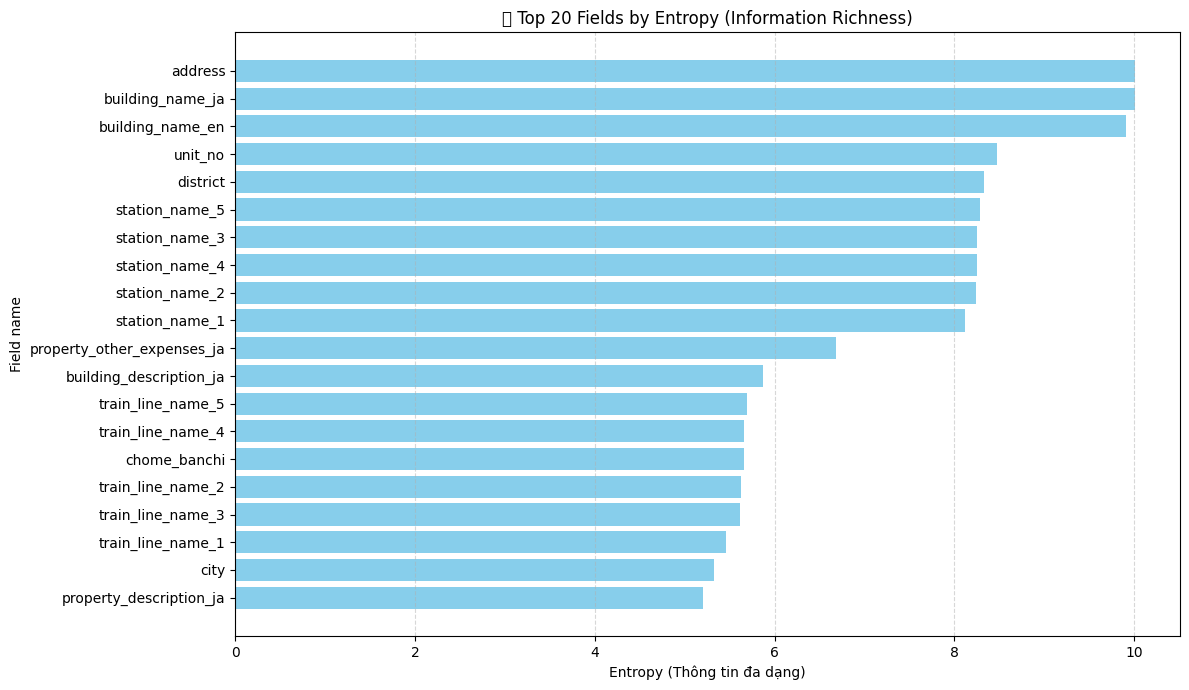

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)  # cho dễ nhìn
pd.set_option('display.max_colwidth', None)  # cho phép hiển thị text dài

analyze_field_importance(df)

# Bước 2: Tạo embedding cho dữ liệu

In [7]:
# Hệ poor nên dùng sentence-transformers/ miễn phí
# Phải dùng model vì câu sẽ có ngữ nghĩa

model_embedding = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

def embedding(sentences):
    if isinstance(sentences, str):
        sentences = [sentences]  # convert str -> list
    return model_embedding.encode(sentences)

sentences = ["Nhà 3 phòng ngủ ở quận 7, giá 5 tỷ"]
embeddings = embedding(sentences)
print(embeddings.shape) # (1, 384)

(1, 768)


In [8]:
# Xem qua cách tính toán

# Danh sách câu hỏi người dùng
questions = [
    "gần ga",
    "giá thuê",
    "cho phép nuôi thú cưng",
    "có chỗ đậu xe"
]

# Danh sách các field muốn so sánh
fields = [
    "station_name", "monthly_rent", "pets", 
    "parking", "city", "building_type"
]

# Tạo vector embeddings
q_vecs = embedding(questions)  # shape (4, 384)
f_vecs = embedding(fields)     # shape (6, 384)

# Tính cosine similarity
similarity = cosine_similarity(f_vecs, q_vecs)  # shape (6,4)
print(similarity)

[[0.62863463 0.18546098 0.11570498 0.25629434]
 [0.19520044 0.8158334  0.21863925 0.25090414]
 [0.19661167 0.1462501  0.67105687 0.18658923]
 [0.4882301  0.3051356  0.233861   0.87702745]
 [0.4762714  0.27711365 0.15856427 0.39292032]
 [0.18088818 0.18009399 0.11419389 0.14521018]]


In [9]:
# Thực hiện lưu trữ vector vào ChromaDB từ df đã chuẩn hóa

# Cấu hình ChromaDB
persist_dir = os.path.join(os.getcwd(), "chroma_db")
collection_name = "property_embeddings"

gc.collect()

# Load hoặc tạo mới ChromaDB client
chroma_client = chromadb.PersistentClient(path=persist_dir)

# Kiểm tra xem collection có tồn tại không
existing_collections = [c.name for c in chroma_client.list_collections()]
db_exists = collection_name in existing_collections

if db_exists:
    print(f"✅ ChromaDB collection '{collection_name}' đã tồn tại, đang load...")
    collection = chroma_client.get_collection(
        name=collection_name,
    )
    print(f"✅ Loaded {collection.count()} documents from existing collection")
else:
    print(f"📝 Tạo collection mới '{collection_name}'...")
    collection = chroma_client.create_collection(
        name=collection_name,
        metadata={"hnsw:space": "cosine"}  # space cosine similarity
    )

# Chỉ thêm dữ liệu nếu collection còn trống
skip_embedding = db_exists and collection.count() > 0

if skip_embedding:
    print(f"⏭️ ChromaDB đã có dữ liệu ({collection.count()} documents), bỏ qua bước embedding")

if not skip_embedding:
    # Chọn metadata quan trọng để filter nhanh
    metadata_fields = [
        "address", "prefecture", "city", "district", "building_name_en", "building_name_ja",
        "monthly_rent", "monthly_maintenance", "numeric_deposit", "numeric_key", "numeric_guarantor", "numeric_agency", "lock_exchange", "fire_insurance", "other_subscription_fees", "numeric_guarantor_max",
        "station_name_1", "train_line_name_1", "station_name_2", "train_line_name_2", "station_name_3", "train_line_name_3", "station_name_4", "train_line_name_4", "station_name_5", "train_line_name_5"
    ]
    
    documents = []
    metadatas = []
    ids = []
    
    # Create info store for db vectors
    for idx, row in df.iterrows():
        row_dict = row.to_dict()
        
        # Tạo text kết hợp các field quan trọng
        property_text = " ".join([f"{k}: {v}" for k, v in row_dict.items() 
                                  if v and v != '' and v != 0])
        
        documents.append(property_text)
        
        # Chỉ lưu metadata cần filter
        metadata_dict = {k: row_dict.get(k) for k in metadata_fields}
        metadatas.append(metadata_dict)
        
        ids.append(f"property_{idx}")
        
    print(f"📊 Total properties to process: {len(documents)}")
    
    # Batch embedding + batch add
    batch_size = 500 # Tùy chỉnh theo RAM
    for i in range(0, len(documents), batch_size):
        batch_texts = documents[i:i+batch_size]
        batch_ids = ids[i:i+batch_size]
        batch_metadata = metadatas[i:i+batch_size]
        
        # Tạo embedding cho batch
        batch_embeddings = embedding(batch_texts).tolist()
        
        # Thêm vào ChromaDB
        collection.add(
            ids=batch_ids,
            embeddings=batch_embeddings,
            documents=batch_texts,
            metadatas=batch_metadata
        )
        
        print(f"✅ Added batch {i} to {i + len(batch_texts)}")
    
    # Lưu trữ dữ liệu xuống đĩa
    print(f"💾 Successfully stored {len(documents)} properties in {persist_dir}")

print(f"📈 Total documents in collection: {collection.count()}")
print(f"✅ ChromaDB database persisted to: {os.path.abspath(persist_dir)}")

✅ ChromaDB collection 'property_embeddings' đã tồn tại, đang load...
✅ Loaded 5705 documents from existing collection
⏭️ ChromaDB đã có dữ liệu (5705 documents), bỏ qua bước embedding
📈 Total documents in collection: 5705
✅ ChromaDB database persisted to: d:\Learn\langchain\rag-simple\llm-normalization-optimize\chroma_db


In [10]:
query_text = '神奈川県川崎市中原区今井仲町8-36, Rent is 315000'
query_emb = np.array(embedding(query_text))

all_docs = collection.get(include=["documents", "metadatas", "embeddings"])
docs = all_docs["documents"]
metadatas = all_docs["metadatas"]
embeddings_saved = all_docs["embeddings"]

candidates = [
    (doc, meta, np.array(emb))
    for doc, meta, emb in zip(docs, metadatas, embeddings_saved)
    if meta.get("city") == "Kawasaki-shi Nakahara-ku"
]

if not candidates:
    print("⚠️ No documents in this city.")
else:
    query_norm = np.linalg.norm(query_emb)
    detailed_results = []
    for doc, meta, doc_vector in candidates:
        doc_norm = np.linalg.norm(doc_vector)
        dot = np.dot(query_emb, doc_vector).item()
        cos_sim = (dot / (query_norm * doc_norm)).item()
        dist = 1 - cos_sim
        detailed_results.append({
            "distance": dist,
            "cos_sim": cos_sim,
            "dot": dot,
            "norm_q": query_norm.item(),
            "norm_d": doc_norm.item(),
            "address": meta["address"],
            "rent": meta.get("monthly_rent"),
            "doc": doc
        })

    detailed_results.sort(key=lambda x: x["distance"])

    for r in detailed_results[:5]:
        print(f"Distance: {r['distance']:.6f}, Address: {r['address']}, Rent: {r['rent']}")

    for r in detailed_results[:5]:
        print(f"Doc: {r['address']}, dot={r['dot']:.4f}, ||Q||={r['norm_q']:.4f}, "
              f"||D||={r['norm_d']:.4f}, cos_sim={r['cos_sim']:.6f}, distance={r['distance']:.6f}")


Distance: 0.447623, Address: 神奈川県川崎市中原区木月1丁目36-18, Rent: 152000
Distance: 0.451757, Address: 神奈川県川崎市中原区井田1丁目13-46ー3, Rent: 253000
Distance: 0.458224, Address: 神奈川県川崎市中原区今井仲町8-36, Rent: 315000
Distance: 0.460942, Address: 神奈川県川崎市中原区今井仲町8-36, Rent: 275000
Distance: 0.461417, Address: 神奈川県川崎市中原区今井仲町8-36, Rent: 280000
Doc: 神奈川県川崎市中原区木月1丁目36-18, dot=4.1874, ||Q||=2.7421, ||D||=2.7645, cos_sim=0.552377, distance=0.447623
Doc: 神奈川県川崎市中原区井田1丁目13-46ー3, dot=4.1941, ||Q||=2.7421, ||D||=2.7898, cos_sim=0.548243, distance=0.451757
Doc: 神奈川県川崎市中原区今井仲町8-36, dot=4.0862, ||Q||=2.7421, ||D||=2.7505, cos_sim=0.541776, distance=0.458224
Doc: 神奈川県川崎市中原区今井仲町8-36, dot=4.0691, ||Q||=2.7421, ||D||=2.7528, cos_sim=0.539058, distance=0.460942
Doc: 神奈川県川崎市中原区今井仲町8-36, dot=4.0696, ||Q||=2.7421, ||D||=2.7556, cos_sim=0.538583, distance=0.461417


# Bước 3: Tối ưu hóa tìm kiếm với LLM

In [11]:
# Ví dụ: Tối ưu hóa tìm kiếm bất động sản với LLM
if llm:
    print("🤖 LLM is configured and ready")
    
    # Original user query
    original_query = "i would like to find a pet-friendly apartment near the station with a monthly rent under 2000"
    print(f"📝 Original query: {original_query}")
    
    # Enhance query with LLM
    enhanced_query = enhance_query_with_llm(original_query)
    print(f"✨ Enhanced query: {enhanced_query}")
    
    # Create embedding from enhanced query
    enhanced_emb = np.array(embedding(enhanced_query))
    
    # Search with enhanced query
    all_docs = collection.get(include=["documents", "metadatas", "embeddings"])
    docs = all_docs["documents"]
    metadatas = all_docs["metadatas"]
    embeddings_saved = all_docs["embeddings"]
    
    # Calculate similarities
    results = []
    for doc, meta, emb in zip(docs, metadatas, embeddings_saved):
        doc_vector = np.array(emb)
        query_norm = np.linalg.norm(enhanced_emb)
        doc_norm = np.linalg.norm(doc_vector)
        if query_norm > 0 and doc_norm > 0:
            cos_sim = (np.dot(enhanced_emb, doc_vector) / (query_norm * doc_norm)).item()
            distance = 1 - cos_sim
            results.append({
                "distance": distance,
                "address": meta.get("address"),
                "rent": meta.get("monthly_rent"),
                "doc": doc
            })
    
    results.sort(key=lambda x: x["distance"])
    
    print(f"\n🔍 Found {len(results)} results")
    print("\n📊 Top 5 Results:")
    for i, r in enumerate(results[:5], 1):
        print(f"{i}. {r['address']} - Rent: {r['rent']}")
    
    # Summarize with LLM
    print("\n🎯 LLM Summary:")
    summary = summarize_results_with_llm(enhanced_query, results)
    print(summary)
else:
    print("⚠️ LLM not configured. Please set COHERE_API_KEY in .env file")

🤖 LLM is configured and ready
📝 Original query: i would like to find a pet-friendly apartment near the station with a monthly rent under 2000
✨ Enhanced query: I want to find a pet-friendly apartment within walking distance of the train station, with a monthly rent of $2,000 or less.

🔍 Found 5705 results

📊 Top 5 Results:
1. 東京都渋谷区道玄坂1丁目17-6 - Rent: 155000
2. 東京都江東区北砂3丁目2-6 - Rent: 216000
3. 東京都江東区北砂3丁目2-6 - Rent: 294000
4. 東京都渋谷区桜丘町4-6 - Rent: 129000
5. 東京都渋谷区桜丘町4-6 - Rent: 130000

🎯 LLM Summary:
Dưới đây là tóm tắt kết quả tìm kiếm căn hộ phù hợp với yêu cầu của bạn (cho phép nuôi thú cưng, gần ga tàu, giá thuê ≤ $2,000/tháng). **Lưu ý: Giá được hiển thị bằng Yên Nhật (JPY)**, cần quy đổi sang USD để so sánh.

### **1. Căn hộ phù hợp (giá ≤ 2,000 USD)**
- **Prospect Shibuya Dogenzaka**  
  - **Địa chỉ**: 1-17-6 Dogenzaka, Shibuya-ku, Tokyo  
  - **Giá**: ¥155,000 (≈ **$1,050 USD** theo tỷ giá 147 JPY/USD)  
  - **Đặc điểm**: Tòa nhà 14 tầng, có bãi đỗ xe, cách ga Shibuya (JR/Tokyo M

# Kết luận: Nếu chỉ tạo bình thường và lưu trữ thì việc truy xuất với vector cho dữ liệu rất không ổn định, giá trị lệch rất nhiều. Sử dụng LLM để cải thiện truy vấn và tóm tắt kết quả làm cho hệ thống RAG hiệu quả hơn.